# Analysis of the number of children in public schools German federal states

## 0. Introduction and Setup

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.data_lit_covid_school as dlcs
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

import yaml

# Function to load credentials from YAML file
def load_credentials(file_path):
    with open(file_path, 'r') as file:
        credentials = yaml.safe_load(file)
    return credentials

def download_genisis(table: str, filename :str, years: str = '1995-2023'):
    credentials = load_credentials(os.path.join(dlcs.PACKAGE_PATH, "../../credentials.yml"))
    user = credentials["user"]
    passwd = credentials["pass"]
    %run ../custom_genesisclient/__init__.py -s 'DESTATIS' -u $user -p $passwd -d $table  -fn $filename -y '1995-2023'


FS_PATH = "../../data/number-school-children"
SCHOOL_TYPE_PATH = "../../data/number-school-children-type-of-school"
download_genisis('21111-0010', FS_PATH)
download_genisis('21111-0004', SCHOOL_TYPE_PATH)

## 1. Data Import and Preparation

In [28]:
from operator import index
import warnings

def load_number_childs_fs(path: str = "../../data/number-school-children.csv") -> pd.DataFrame:
    """Load table from destatis excel file"""
    df = pd.read_csv(os.path.join(dlcs.PACKAGE_PATH ,path), sep=";", skiprows=5, skipfooter=4, engine="python")
    df.replace("b'", "", inplace=True, regex=True)
    df.rename(columns={"b'": "School Year"}, inplace=True)
    df.rename(columns={"Baden-W\\xc3\\xbcrttemberg": "Baden-Württemberg"}, inplace=True)
    df.rename(columns={"Th\\xc3\\xbcringen": "Thüringen"}, inplace=True)
    
  
    # Generate gender column
    num_years = 26
    male = df.iloc[:num_years + 3].index
    female = df.iloc[num_years + 3:].index
    all = df.iloc[2 * num_years + 4:].index
    df["gender"] = np.nan
    df.iloc[male, -1] = "m"
    df.iloc[female, -1] = "f"
    df.iloc[all, -1] = "all"
    df.drop([1,2,29,56], inplace=True)
    
    # Build own melted table --> may be done better
    temp = pd.DataFrame(columns=["Federal State", "Gender", "Type", "Value", "Year"])
    for col_index in range(1, len(df.columns)-1, 3):
        for index in df.index[1:]:
            year = df.loc[index, "School Year"]
            gender = df.loc[index, "gender"]
            federal_state = df.columns[col_index]
            temp.loc[len(temp)] = [federal_state, gender, "Pupils", df.loc[index][df.columns[col_index]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School beginners", df.loc[index][df.columns[col_index + 1]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School leavers (graduates and dropouts)", df.loc[index][df.columns[col_index + 2]], year]
            
    df = temp
    df['Value'] = df['Value'].str.replace("'", '')
    df.replace(" ", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("'", "", inplace=True)
    df["Value"] = df["Value"].astype(float)
    df["Year"] = df["Year"].replace("/.*", "", regex=True).astype(int)
    df = df[df["Year"] >= 1998]
    return df

# Load the data and display 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = load_number_childs_fs()
data

,Federal State,Gender,Type,Value,Year
3,Baden-Württemberg,m,Pupils,650777.0,1998
4,Baden-Württemberg,m,School beginners,NaN,1998
5,Baden-Württemberg,m,School leavers (graduates and dropouts),58589.0,1998
6,Baden-Württemberg,m,Pupils,658612.0,1999
7,Baden-Württemberg,m,School beginners,62803.0,1999
...,...,...,...,...,...
3739,Thüringen,all,School beginners,18759.0,2021
3740,Thüringen,all,School leavers (graduates and dropouts),17811.0,2021
3741,Thüringen,all,Pupils,205640.0,2022
3742,Thüringen,all,School beginners,19518.0,2022


In [ ]:
def load_number_childs_school_type(path: str = "../../data/number-school-children.csv"):
    pass

# Plot the number of school children per federal state per year

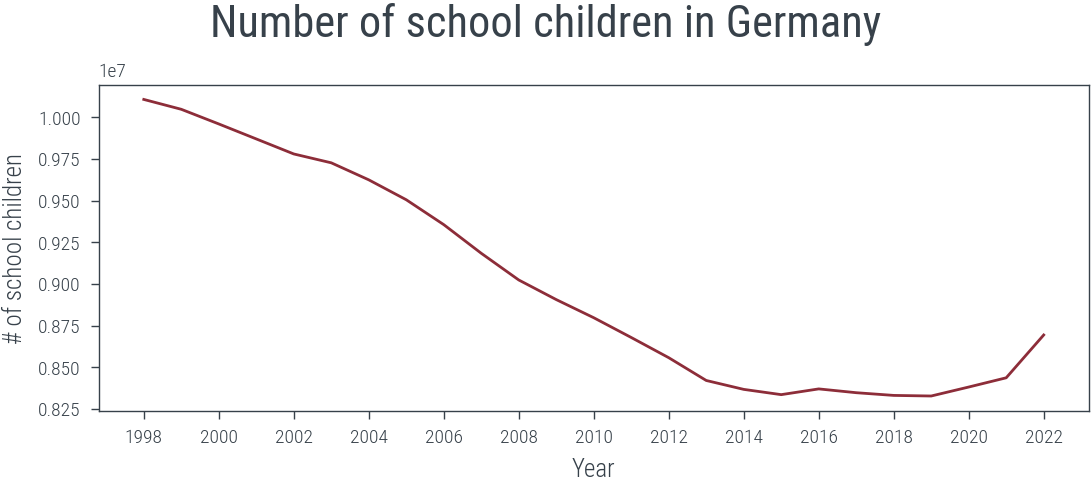

In [23]:
# Plot the data
fig, ax = plt.subplots(1, 1)


aggregated = data.groupby(["Year", "Gender", "Type"]).apply(lambda x: x["Value"].sum()).reset_index()
aggregated.rename(columns={0: "Value"}, inplace=True)

male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "f"]
all = aggregated.loc[aggregated["Gender"] == "all"]

ax.plot(all[all["Type"] == "Pupils"]["Year"], all[all["Type"] == "Pupils"]["Value"])

ax.set_xlabel("Year")
ax.set_ylabel("# of school children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))

# Other settings
fig.suptitle("Number of school children in Germany", fontsize=16)

plt.show()

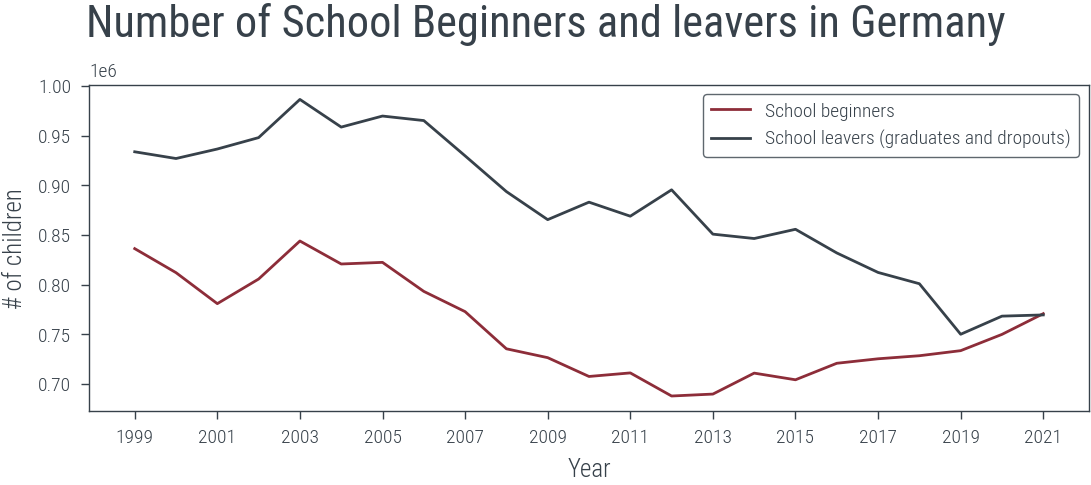

In [24]:
# Plot the data
fig, ax = plt.subplots(1, 1)


aggregated = data.groupby(["Year", "Gender", "Type"]).apply(lambda x: x["Value"].sum()).reset_index()
aggregated = aggregated[aggregated["Year"] >= 1999].loc[aggregated["Year"] <= 2021]
aggregated.rename(columns={0: "Value"}, inplace=True)

male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "f"]
all = aggregated.loc[aggregated["Gender"] == "all"]
ax.plot(all[all["Type"] == "School beginners"]["Year"], all[all["Type"] == "School beginners"]["Value"])
ax.plot(all[all["Type"] == "School leavers (graduates and dropouts)"]["Year"], all[all["Type"] == "School leavers (graduates and dropouts)"]["Value"])


ax.set_xlabel("Year")
ax.set_ylabel("# of children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))
ax.legend(["School beginners", "School leavers (graduates and dropouts)"])

# Other settings
fig.suptitle("Number of School Beginners and leavers in Germany", fontsize=16)

plt.show()